# 타이타닉 생존자 예측 (Titanic Survival Prediction) - AUC 최적화 버전

본 노트북은 Kaggle의 [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic/data) 데이터를 기반으로 생존자를 예측합니다.

## 📊 데이터셋 설명
| 변수 | 설명 |
|------|------|
| Survival | 0 = 사망, 1 = 생존 |
| Pclass | 티켓 등급 (1 = 1등석, 2 = 2등석, 3 = 3등석) |
| Sex | 성별 |
| Age | 나이 |
| SibSp | 함께 탑승한 형제자매, 배우자 수 |
| Parch | 함께 탑승한 부모, 자녀 수 |
| Ticket | 티켓 번호 |
| Fare | 요금 |
| Cabin | 객실 번호 |
| Embarked | 탑승 항구 (C = Cherbourg, Q = Queenstown, S = Southampton) |

## 🎯 AUC 최적화 전략
1. **고급 전처리**: Pclass+Sex별 Age 대치, Deck 추출, Title 세분화, FarePerPerson
2. **Optuna 기반 하이퍼파라미터 튜닝**: 30분 내 최대 탐색
3. **앙상블 최적화**: Weighted Voting, Stacking
4. **과적합 방지**: Early Stopping, 정규화

In [1]:
!pip install scikit-learn==1.5.2

In [2]:
# ============================================================
# 1. 라이브러리 설치 및 임포트
# ============================================================
# 필요 시 주석 해제 후 실행
# !pip install xgboost lightgbm catboost plotly seaborn optuna imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time

# 모델링 라이브러리
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report

# 머신러닝 모델
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, ExtraTreesClassifier, 
                              VotingClassifier, StackingClassifier, HistGradientBoostingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# 고성능 부스팅 모델
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 하이퍼파라미터 튜닝
import optuna
from optuna.samplers import TPESampler

# 불균형 데이터 처리
from imblearn.over_sampling import SMOTE

# 경고 무시
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 한글 폰트 설정 (Windows 환경)
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

print("✅ 라이브러리 임포트 완료")

✅ 라이브러리 임포트 완료


c:\Users\user\miniconda3\envs\DS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ============================================================
# 2. 데이터 불러오기
# ============================================================
base_path = r'C:\Users\user\github\DataScience\scikit-learn\scikit-learn\data\titanic'
train_df = pd.read_csv(f'{base_path}/train.csv')
test_df = pd.read_csv(f'{base_path}/test.csv')

print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")
print(f"\n결측치 현황:")
print(train_df.isnull().sum())

Train Shape: (891, 12)
Test Shape: (418, 11)

결측치 현황:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


## 3. 🔧 고급 전처리 (Advanced Preprocessing)
Kaggle 상위 솔루션에서 검증된 기법들을 적용합니다:
1. **Age**: Pclass + Sex 그룹별 median으로 대치 (단순 median보다 정확)
2. **Deck**: Cabin 첫 글자에서 추출 (생존율과 연관)
3. **Title**: Name에서 호칭 추출 및 세분화
4. **FarePerPerson**: Fare / FamilySize (1인당 요금)
5. **Age/Fare Binning**: 연속형 → 범주형 변환

In [4]:
# ============================================================
# 3. 고급 전처리 함수 정의
# ============================================================

def advanced_preprocessing(train_df, test_df):
    """
    Kaggle 상위 솔루션 기반 고급 전처리 함수
    AUC 향상을 위한 다양한 Feature Engineering 포함
    """
    # Train과 Test를 합쳐서 일관된 전처리 수행
    all_data = pd.concat([train_df, test_df], ignore_index=True)
    
    # ========== 1. Title 추출 (Name에서) ==========
    # 호칭은 사회적 지위, 나이, 성별을 나타내는 강력한 특성
    all_data['Title'] = all_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Title 그룹화 (희귀 호칭 통합)
    title_mapping = {
        'Mr': 'Mr',
        'Miss': 'Miss',
        'Mrs': 'Mrs',
        'Master': 'Master',  # 어린 남자아이
        'Dr': 'Officer',
        'Rev': 'Officer',
        'Col': 'Officer',
        'Major': 'Officer',
        'Capt': 'Officer',
        'Mlle': 'Miss',      # 프랑스어 Miss
        'Ms': 'Miss',
        'Mme': 'Mrs',        # 프랑스어 Mrs
        'Lady': 'Royalty',
        'Countess': 'Royalty',
        'Sir': 'Royalty',
        'Don': 'Royalty',
        'Dona': 'Royalty',
        'Jonkheer': 'Royalty'
    }
    all_data['Title'] = all_data['Title'].map(title_mapping).fillna('Other')
    print(f"Title 분포:\n{all_data['Title'].value_counts()}")
    
    # ========== 2. FamilySize 생성 ==========
    all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1
    
    # 가족 크기 범주화 (생존율 패턴 반영)
    all_data['FamilySizeGroup'] = pd.cut(all_data['FamilySize'], 
                                          bins=[0, 1, 4, 11], 
                                          labels=['Alone', 'Small', 'Large'])
    
    # ========== 3. Age 그룹별 대치 (Pclass + Sex + Title 기반) ==========
    # 단순 median보다 더 정확한 대치
    age_median = all_data.groupby(['Pclass', 'Sex', 'Title'])['Age'].transform('median')
    all_data['Age'] = all_data['Age'].fillna(age_median)
    # 여전히 결측인 경우 전체 median 사용
    all_data['Age'] = all_data['Age'].fillna(all_data['Age'].median())
    
    # Age 구간화 (비선형 관계 포착)
    all_data['AgeBin'] = pd.cut(all_data['Age'], 
                                 bins=[0, 12, 20, 40, 60, 100], 
                                 labels=['Child', 'Teenager', 'Adult', 'Middle', 'Senior'])
    
    # ========== 4. Fare 처리 ==========
    all_data['Fare'] = all_data['Fare'].fillna(all_data['Fare'].median())
    
    # 1인당 요금 계산 (가족과 함께 타면 요금 분담)
    all_data['FarePerPerson'] = all_data['Fare'] / all_data['FamilySize']
    
    # Fare 구간화
    all_data['FareBin'] = pd.qcut(all_data['Fare'], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'])
    
    # ========== 5. Deck 추출 (Cabin 첫 글자) ==========
    all_data['Deck'] = all_data['Cabin'].str[0].fillna('Unknown')
    # 희귀 Deck 통합
    deck_mapping = {'A': 'ABC', 'B': 'ABC', 'C': 'ABC', 'D': 'DE', 'E': 'DE', 
                    'F': 'FG', 'G': 'FG', 'T': 'Unknown', 'Unknown': 'Unknown'}
    all_data['Deck'] = all_data['Deck'].map(deck_mapping)
    
    # ========== 6. Embarked 처리 ==========
    all_data['Embarked'] = all_data['Embarked'].fillna(all_data['Embarked'].mode()[0])
    
    # ========== 7. Ticket Prefix 추출 ==========
    def get_ticket_prefix(ticket):
        if ticket.isdigit():
            return 'NUM'
        else:
            prefix = ticket.split()[0].replace('.', '').replace('/', '')
            return prefix if len(prefix) <= 4 else prefix[:4]
    
    all_data['TicketPrefix'] = all_data['Ticket'].apply(get_ticket_prefix)
    # 희귀 prefix 통합
    ticket_counts = all_data['TicketPrefix'].value_counts()
    rare_tickets = ticket_counts[ticket_counts < 10].index
    all_data['TicketPrefix'] = all_data['TicketPrefix'].replace(rare_tickets, 'Rare')
    
    # ========== 8. 범주형 변수 인코딩 ==========
    # Sex 변환 (숫자로)
    all_data['Sex'] = (all_data['Sex'] == 'male').astype(int)  # male=1, female=0
    
    # Label Encoding
    label_cols = ['Title', 'Embarked', 'FamilySizeGroup', 'AgeBin', 'FareBin', 'Deck', 'TicketPrefix']
    for col in label_cols:
        le = LabelEncoder()
        all_data[col] = le.fit_transform(all_data[col].astype(str))
    
    # ========== 9. 불필요한 컬럼 삭제 ==========
    drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    all_data = all_data.drop(columns=drop_cols, errors='ignore')
    
    # Train/Test 분리
    train_processed = all_data.iloc[:len(train_df)].copy()
    test_processed = all_data.iloc[len(train_df):].copy()
    
    print(f"\n✅ 전처리 완료")
    print(f"최종 특성 수: {train_processed.shape[1]}")
    print(f"특성 목록: {train_processed.columns.tolist()}")
    
    return train_processed, test_processed

# 전처리 실행
train_processed, test_processed = advanced_preprocessing(train_df, test_df)
train_processed.head()

Title 분포:
Title
Mr         757
Miss       264
Mrs        198
Master      61
Officer     23
Royalty      6
Name: count, dtype: int64

✅ 전처리 완료
최종 특성 수: 16
특성 목록: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'FamilySize', 'FamilySizeGroup', 'AgeBin', 'FarePerPerson', 'FareBin', 'Deck', 'TicketPrefix']


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,FamilySizeGroup,AgeBin,FarePerPerson,FareBin,Deck,TicketPrefix
0,0.0,3,1,22.0,1,0,7.2500,2,2,2,2,0,3.62500,1,3,1
1,1.0,1,0,38.0,1,0,71.2833,0,3,2,2,0,35.64165,3,0,4
2,1.0,3,0,26.0,0,0,7.9250,2,1,1,0,0,7.92500,2,3,8
3,1.0,1,0,35.0,1,0,53.1000,2,3,2,2,0,26.55000,3,0,3
4,0.0,3,1,35.0,0,0,8.0500,2,2,1,0,0,8.05000,2,3,3


In [5]:
# ============================================================
# 4. 학습 데이터 준비
# ============================================================
X = train_processed.drop('Survived', axis=1)
y = train_processed['Survived'].astype(int)

# Stratified Split (클래스 비율 유지)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}")
print(f"Target 분포: 0={sum(y==0)}, 1={sum(y==1)}")

Train: (712, 15), Validation: (179, 15)
Target 분포: 0=549, 1=342


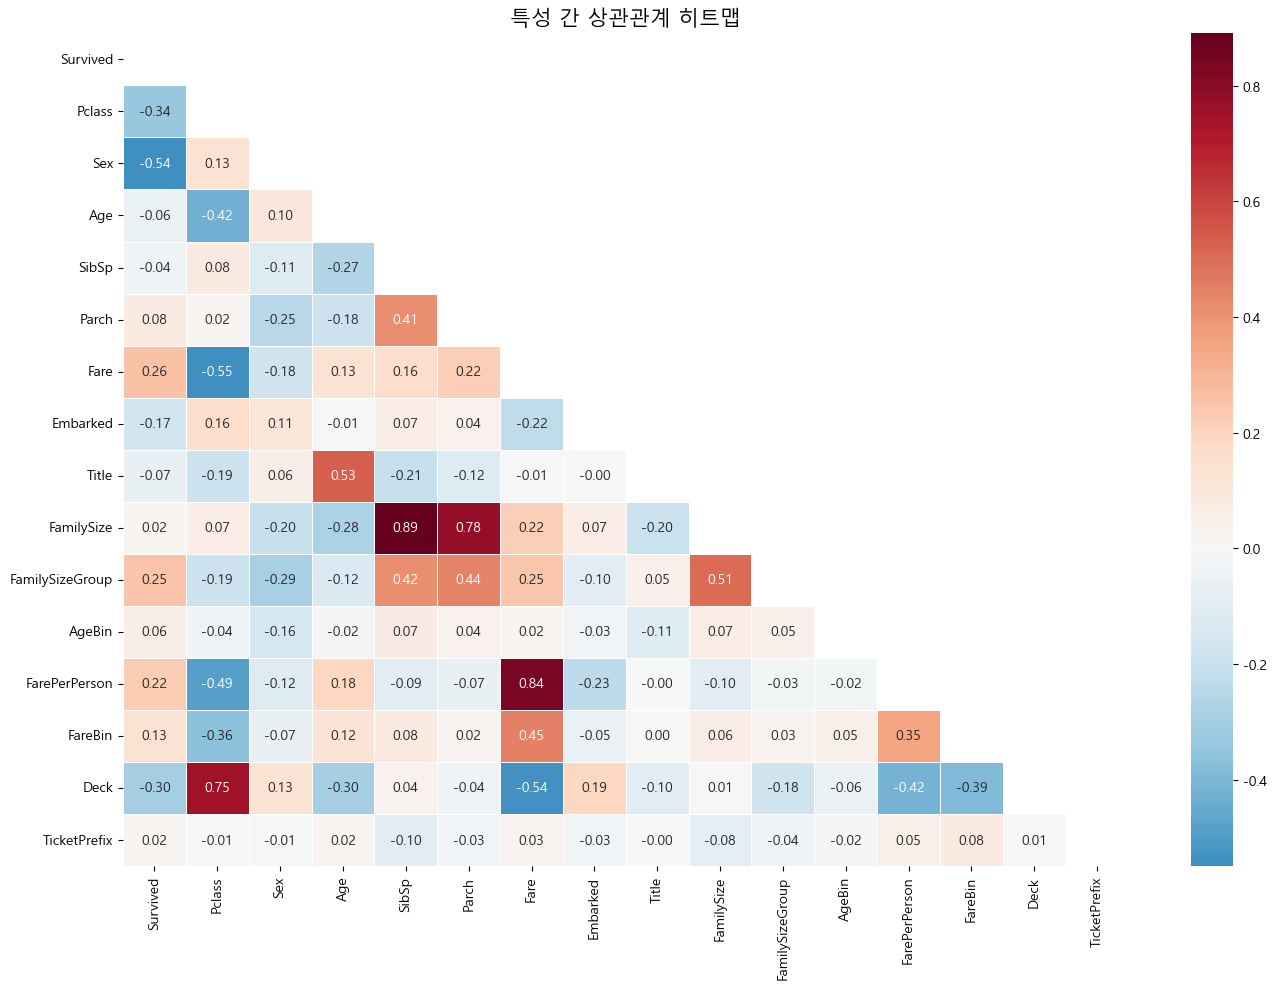


Survived와의 상관관계:
Sex               -0.543351
Pclass            -0.338481
Deck              -0.301088
Fare               0.257307
FamilySizeGroup    0.249714
FarePerPerson      0.221600
Embarked          -0.167675
FareBin            0.127907
Parch              0.081629
Title             -0.066464
Age               -0.059594
AgeBin             0.058982
SibSp             -0.035322
TicketPrefix       0.017002
FamilySize         0.016639
Name: Survived, dtype: float64


In [6]:
# ============================================================
# 5. EDA 시각화 (Plotly)
# ============================================================

# 5.1 상관관계 히트맵
plt.figure(figsize=(14, 10))
corr = train_processed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu_r', 
            center=0, fmt='.2f', linewidths=0.5)
plt.title('특성 간 상관관계 히트맵', fontsize=15)
plt.tight_layout()
plt.show()

# 5.2 생존 여부와 상관관계가 높은 특성
target_corr = corr['Survived'].drop('Survived').sort_values(key=abs, ascending=False)
print("\nSurvived와의 상관관계:")
print(target_corr)

## 6. 🚀 Optuna 기반 하이퍼파라미터 튜닝
30분 내에 최적의 파라미터를 찾기 위해 Optuna(베이지안 최적화)를 사용합니다.
- **과적합 방지**: 정규화 파라미터 포함, Cross-Validation 사용
- **CPU 최대 활용**: n_jobs=-1

In [7]:
# ============================================================
# 6. Optuna 하이퍼파라미터 튜닝 (XGBoost)
# ============================================================

def objective_xgb(trial):
    """XGBoost 최적화 목표 함수"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),  # L1 정규화
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # L2 정규화
        'gamma': trial.suggest_float('gamma', 0, 5),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'auc',
        'n_jobs': -1
    }
    
    model = XGBClassifier(**params)
    
    # 5-Fold Stratified CV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    
    return scores.mean()

# 튜닝 실행 (10분 제한 또는 200 trials)
print("XGBoost 하이퍼파라미터 튜닝 시작...")
study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_xgb.optimize(objective_xgb, n_trials=200, timeout=600, show_progress_bar=True)

print(f"\n🏆 XGBoost 최적 AUC: {study_xgb.best_value:.4f}")
print(f"최적 파라미터: {study_xgb.best_params}")

XGBoost 하이퍼파라미터 튜닝 시작...


Best trial: 181. Best value: 0.89692: 100%|██████████| 200/200 [00:32<00:00,  6.20it/s, 32.28/600 seconds] 


🏆 XGBoost 최적 AUC: 0.8969
최적 파라미터: {'n_estimators': 971, 'max_depth': 7, 'learning_rate': 0.046181712756484056, 'subsample': 0.6120350391111248, 'colsample_bytree': 0.8962978116963475, 'min_child_weight': 7, 'reg_alpha': 0.004593066184892314, 'reg_lambda': 1.1863761970289609e-07, 'gamma': 0.8031657545046058}


In [8]:
# ============================================================
# 7. Optuna - LightGBM 튜닝
# ============================================================

def objective_lgbm(trial):
    """LightGBM 최적화 목표 함수"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'verbose': -1,
        'n_jobs': -1
    }
    
    model = LGBMClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    
    return scores.mean()

print("LightGBM 하이퍼파라미터 튜닝 시작...")
study_lgbm = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_lgbm.optimize(objective_lgbm, n_trials=200, timeout=600, show_progress_bar=True)

print(f"\n🏆 LightGBM 최적 AUC: {study_lgbm.best_value:.4f}")
print(f"최적 파라미터: {study_lgbm.best_params}")

LightGBM 하이퍼파라미터 튜닝 시작...


Best trial: 152. Best value: 0.897199: 100%|██████████| 200/200 [01:28<00:00,  2.27it/s, 88.16/600 seconds]


🏆 LightGBM 최적 AUC: 0.8972
최적 파라미터: {'n_estimators': 242, 'max_depth': 6, 'learning_rate': 0.18169542323085702, 'num_leaves': 58, 'subsample': 0.7452699375588069, 'colsample_bytree': 0.6785065894471553, 'min_child_samples': 90, 'reg_alpha': 0.0188224933689616, 'reg_lambda': 0.004559575829633777}


In [9]:
# ============================================================
# 8. Optuna - CatBoost 튜닝 (수동 CV - sklearn 호환성 문제 해결)
# ============================================================
def objective_catboost(trial):
    """CatBoost 최적화 목표 함수 - 수동 CV 사용"""
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
        'random_strength': trial.suggest_float('random_strength', 0, 10),
        'random_seed': 42,
        'verbose': 0,
        'thread_count': -1
    }
    
    # 수동 5-Fold CV (sklearn cross_val_score와 CatBoost 호환성 문제 해결)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = CatBoostClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        pred_prob = model.predict_proba(X_fold_val)[:, 1]
        auc = roc_auc_score(y_fold_val, pred_prob)
        scores.append(auc)
    
    return np.mean(scores)
print("CatBoost 하이퍼파라미터 튜닝 시작...")
study_catboost = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_catboost.optimize(objective_catboost, n_trials=150, timeout=600, show_progress_bar=True)
print(f"\n🏆 CatBoost 최적 AUC: {study_catboost.best_value:.4f}")
print(f"최적 파라미터: {study_catboost.best_params}")

CatBoost 하이퍼파라미터 튜닝 시작...


Best trial: 123. Best value: 0.896351: 100%|██████████| 150/150 [07:54<00:00,  3.16s/it, 474.50/600 seconds]


🏆 CatBoost 최적 AUC: 0.8964
최적 파라미터: {'iterations': 423, 'depth': 4, 'learning_rate': 0.18134238063302646, 'l2_leaf_reg': 9.806185376330365, 'border_count': 217, 'bagging_temperature': 9.133724523387981, 'random_strength': 0.4858139557160086}


In [10]:
# ============================================================
# 9. 최적 모델로 학습 및 평가
# ============================================================

# 최적 파라미터로 모델 생성
best_xgb = XGBClassifier(**study_xgb.best_params, random_state=42, 
                          use_label_encoder=False, eval_metric='auc', n_jobs=-1)
best_lgbm = LGBMClassifier(**study_lgbm.best_params, random_state=42, verbose=-1, n_jobs=-1)
best_catboost = CatBoostClassifier(**study_catboost.best_params, random_seed=42, verbose=0)

# 학습
best_xgb.fit(X_train, y_train)
best_lgbm.fit(X_train, y_train)
best_catboost.fit(X_train, y_train)

# 검증 세트 평가
models_tuned = {
    'XGBoost (Tuned)': best_xgb,
    'LightGBM (Tuned)': best_lgbm,
    'CatBoost (Tuned)': best_catboost
}

print("\n📊 최적화된 모델 성능 (Validation Set):")
print("="*50)
for name, model in models_tuned.items():
    pred_prob = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, pred_prob)
    acc = accuracy_score(y_val, model.predict(X_val))
    print(f"{name}: AUC={auc:.4f}, Accuracy={acc:.4f}")


📊 최적화된 모델 성능 (Validation Set):
XGBoost (Tuned): AUC=0.8553, Accuracy=0.8268
LightGBM (Tuned): AUC=0.8492, Accuracy=0.8045
CatBoost (Tuned): AUC=0.8308, Accuracy=0.7877


In [12]:
# ============================================================

# 10. 앙상블 (Weighted Soft Voting + Stacking)

# ============================================================



# 10.1 Weighted Soft Voting (AUC 비율 기반 가중치)

auc_xgb = roc_auc_score(y_val, best_xgb.predict_proba(X_val)[:, 1])

auc_lgbm = roc_auc_score(y_val, best_lgbm.predict_proba(X_val)[:, 1])

auc_cat = roc_auc_score(y_val, best_catboost.predict_proba(X_val)[:, 1])



total_auc = auc_xgb + auc_lgbm + auc_cat

weights = [auc_xgb/total_auc, auc_lgbm/total_auc, auc_cat/total_auc]

print(f"앙상블 가중치: XGB={weights[0]:.3f}, LGBM={weights[1]:.3f}, CatBoost={weights[2]:.3f}")



# Weighted Voting

weighted_voting = VotingClassifier(

    estimators=[('xgb', best_xgb), ('lgbm', best_lgbm), ('catboost', best_catboost)],

    voting='soft',

    weights=weights

)

weighted_voting.fit(X_train, y_train)

weighted_auc = roc_auc_score(y_val, weighted_voting.predict_proba(X_val)[:, 1])

print(f"\nWeighted Soft Voting AUC: {weighted_auc:.4f}")



# 10.2 Stacking with Ridge meta-learner

stacking_clf = StackingClassifier(

    estimators=[('xgb', best_xgb), ('lgbm', best_lgbm), ('catboost', best_catboost)],

    final_estimator=LogisticRegression(C=0.1, max_iter=1000),

    cv=5,

    n_jobs=-1,

    passthrough=True  # 원본 특성도 메타 모델에 전달

)

stacking_clf.fit(X_train, y_train)

stacking_auc = roc_auc_score(y_val, stacking_clf.predict_proba(X_val)[:, 1])

print(f"Stacking Ensemble AUC: {stacking_auc:.4f}")

앙상블 가중치: XGB=0.337, LGBM=0.335, CatBoost=0.328

Weighted Soft Voting AUC: 0.8542
Stacking Ensemble AUC: 0.8584


In [13]:
# ============================================================
# 11. SMOTE 적용 비교
# ============================================================

# SMOTE 적용
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"SMOTE 전: {X_train.shape}, 후: {X_train_smote.shape}")
print(f"Target 분포 (전): {dict(y_train.value_counts())}")
print(f"Target 분포 (후): {dict(pd.Series(y_train_smote).value_counts())}")

# SMOTE 데이터로 XGBoost 학습
xgb_smote = XGBClassifier(**study_xgb.best_params, random_state=42, 
                           use_label_encoder=False, eval_metric='auc', n_jobs=-1)
xgb_smote.fit(X_train_smote, y_train_smote)
auc_smote = roc_auc_score(y_val, xgb_smote.predict_proba(X_val)[:, 1])

print(f"\nXGBoost (Original) AUC: {auc_xgb:.4f}")
print(f"XGBoost (SMOTE) AUC: {auc_smote:.4f}")
print(f"차이: {auc_smote - auc_xgb:+.4f}")

SMOTE 전: (712, 15), 후: (878, 15)
Target 분포 (전): {0: np.int64(439), 1: np.int64(273)}
Target 분포 (후): {1: np.int64(439), 0: np.int64(439)}

XGBoost (Original) AUC: 0.8553
XGBoost (SMOTE) AUC: 0.8485
차이: -0.0068


In [14]:
# ============================================================
# 12. 최종 결과 요약
# ============================================================

# 모든 모델 AUC 비교
final_results = {
    'XGBoost (Tuned)': auc_xgb,
    'LightGBM (Tuned)': auc_lgbm,
    'CatBoost (Tuned)': auc_cat,
    'Weighted Voting': weighted_auc,
    'Stacking Ensemble': stacking_auc,
    'XGBoost + SMOTE': auc_smote
}

results_df = pd.DataFrame(list(final_results.items()), columns=['Model', 'AUC'])
results_df = results_df.sort_values('AUC', ascending=False)

# 시각화
fig = px.bar(results_df, x='AUC', y='Model', orientation='h',
             title='🏆 최종 모델 AUC 비교',
             color='AUC', color_continuous_scale='viridis')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

print("\n" + "="*60)
print("📊 최종 결과 요약")
print("="*60)
for _, row in results_df.iterrows():
    print(f"{row['Model']}: AUC = {row['AUC']:.4f}")
    
best_model_name = results_df.iloc[0]['Model']
best_auc = results_df.iloc[0]['AUC']
print(f"\n🥇 최고 성능 모델: {best_model_name} (AUC: {best_auc:.4f})")


📊 최종 결과 요약
Stacking Ensemble: AUC = 0.8584
XGBoost (Tuned): AUC = 0.8553
Weighted Voting: AUC = 0.8542
LightGBM (Tuned): AUC = 0.8492
XGBoost + SMOTE: AUC = 0.8485
CatBoost (Tuned): AUC = 0.8308

🥇 최고 성능 모델: Stacking Ensemble (AUC: 0.8584)


In [15]:
# ============================================================
# 13. Kaggle 제출용 CSV 파일 생성 (호환성 문제 해결 버전)
# ============================================================
import os
# 저장 경로 설정
submission_path = r'C:\Users\user\github\DataScience\scikit-learn\scikit-learn\Submission'
os.makedirs(submission_path, exist_ok=True)
# 원본 test_df에서 PassengerId 가져오기
passenger_ids = test_df['PassengerId']
# test_processed에서 Survived 컬럼 제거
X_test = test_processed.drop('Survived', axis=1, errors='ignore')
print("테스트 데이터 예측 시작...")
print(f"저장 경로: {submission_path}")
print("="*50)
# ========== 1. Soft Voting 예측 (수동 구현) ==========
# 각 모델 전체 데이터로 재학습
best_xgb.fit(X, y)
best_lgbm.fit(X, y)
best_catboost.fit(X, y)
# 확률 예측
prob_xgb = best_xgb.predict_proba(X_test)[:, 1]
prob_lgbm = best_lgbm.predict_proba(X_test)[:, 1]
prob_cat = best_catboost.predict_proba(X_test)[:, 1]
# 가중 평균 (Soft Voting)
soft_prob = (weights[0] * prob_xgb + weights[1] * prob_lgbm + weights[2] * prob_cat)
soft_pred = (soft_prob >= 0.5).astype(int)
submission_soft = pd.DataFrame({'PassengerId': passenger_ids, 'Survived': soft_pred})
submission_soft.to_csv(f'{submission_path}/submission_soft_voting.csv', index=False)
print(f"✅ Soft Voting 저장 완료 (생존: {sum(soft_pred)}/{len(soft_pred)})")
# ========== 2. Hard Voting 예측 (수동 구현) ==========
pred_xgb = best_xgb.predict(X_test)
pred_lgbm = best_lgbm.predict(X_test)
pred_cat = best_catboost.predict(X_test)
# 다수결 (Hard Voting)
hard_pred = ((pred_xgb + pred_lgbm + pred_cat) >= 2).astype(int)
submission_hard = pd.DataFrame({'PassengerId': passenger_ids, 'Survived': hard_pred})
submission_hard.to_csv(f'{submission_path}/submission_hard_voting.csv', index=False)
print(f"✅ Hard Voting 저장 완료 (생존: {sum(hard_pred)}/{len(hard_pred)})")
# ========== 3. Stacking 예측 (수동 구현) ==========
# 메타 특성 생성 (각 모델의 확률 예측)
from sklearn.model_selection import cross_val_predict
# 학습 데이터에 대한 OOF(Out-of-Fold) 예측
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# XGBoost OOF
oof_xgb = np.zeros(len(X))
for train_idx, val_idx in cv.split(X, y):
    best_xgb.fit(X.iloc[train_idx], y.iloc[train_idx])
    oof_xgb[val_idx] = best_xgb.predict_proba(X.iloc[val_idx])[:, 1]
# LightGBM OOF
oof_lgbm = np.zeros(len(X))
for train_idx, val_idx in cv.split(X, y):
    best_lgbm.fit(X.iloc[train_idx], y.iloc[train_idx])
    oof_lgbm[val_idx] = best_lgbm.predict_proba(X.iloc[val_idx])[:, 1]
# CatBoost OOF
oof_cat = np.zeros(len(X))
for train_idx, val_idx in cv.split(X, y):
    best_catboost.fit(X.iloc[train_idx], y.iloc[train_idx])
    oof_cat[val_idx] = best_catboost.predict_proba(X.iloc[val_idx])[:, 1]
# 메타 특성으로 메타 모델 학습
meta_train = np.column_stack([oof_xgb, oof_lgbm, oof_cat])
meta_model = LogisticRegression(C=0.1, max_iter=1000)
meta_model.fit(meta_train, y)
# 테스트 데이터에 대한 메타 특성 생성
best_xgb.fit(X, y)
best_lgbm.fit(X, y)
best_catboost.fit(X, y)
meta_test = np.column_stack([
    best_xgb.predict_proba(X_test)[:, 1],
    best_lgbm.predict_proba(X_test)[:, 1],
    best_catboost.predict_proba(X_test)[:, 1]
])
stacking_pred = meta_model.predict(meta_test)
submission_stacking = pd.DataFrame({'PassengerId': passenger_ids, 'Survived': stacking_pred})
submission_stacking.to_csv(f'{submission_path}/submission_stacking.csv', index=False)
print(f"✅ Stacking 저장 완료 (생존: {sum(stacking_pred)}/{len(stacking_pred)})")
# ========== 4. SMOTE + XGBoost 예측 ==========
smote_full = SMOTE(random_state=42)
X_smote_full, y_smote_full = smote_full.fit_resample(X, y)
xgb_smote_full = XGBClassifier(**study_xgb.best_params, random_state=42,
                                use_label_encoder=False, eval_metric='auc', n_jobs=-1)
xgb_smote_full.fit(X_smote_full, y_smote_full)
smote_pred = xgb_smote_full.predict(X_test)
submission_smote = pd.DataFrame({'PassengerId': passenger_ids, 'Survived': smote_pred})
submission_smote.to_csv(f'{submission_path}/submission_smote_xgboost.csv', index=False)
print(f"✅ SMOTE 저장 완료 (생존: {sum(smote_pred)}/{len(smote_pred)})")
print("\n🎉 모든 제출 파일 생성 완료!")

테스트 데이터 예측 시작...
저장 경로: C:\Users\user\github\DataScience\scikit-learn\scikit-learn\Submission
✅ Soft Voting 저장 완료 (생존: 156/418)
✅ Hard Voting 저장 완료 (생존: 155/418)
✅ Stacking 저장 완료 (생존: 150/418)
✅ SMOTE 저장 완료 (생존: 158/418)

🎉 모든 제출 파일 생성 완료!


## 📋 튜닝 가능 파라미터 정리

### XGBoost / LightGBM / CatBoost 공통
| 파라미터 | 설명 | 권장 범위 |
|----------|------|----------|
| learning_rate | 학습률 | 0.01 ~ 0.3 |
| n_estimators | 트리 개수 | 100 ~ 1000 |
| max_depth | 트리 깊이 | 3 ~ 10 |
| subsample | 데이터 샘플링 비율 | 0.6 ~ 1.0 |
| colsample_bytree | 특성 샘플링 비율 | 0.6 ~ 1.0 |
| reg_alpha (L1) | L1 정규화 | 1e-8 ~ 10 |
| reg_lambda (L2) | L2 정규화 | 1e-8 ~ 10 |

### SMOTE 파라미터
| 파라미터 | 설명 |
|----------|------|
| sampling_strategy | 오버샘플링 비율 (auto, 0.5~1.0) |
| k_neighbors | 이웃 수 (기본 5) |

### 과적합 방지 전략
1. **정규화**: reg_alpha, reg_lambda 값 증가
2. **트리 깊이 제한**: max_depth 낮추기
3. **Early Stopping**: validation set 기반
4. **Cross-Validation**: 5-fold Stratified CV 사용